This notebook is to recreate and play with "
[Interim research report] Taking features out of superposition with sparse autoencoders" by Lee Sharkey, Dan Braun, beren

https://www.lesswrong.com/posts/z6QQJbtpkEAX3Aojj/interim-research-report-taking-features-out-of-superposition

**Started:** 2023.05.30 

**Author:** Adam Shai

Change Log:
* 2023.05.30: Implemented the Toy Dataset Generation and the first two plots from the LW post

# Toy Dataset Generation

In [3]:
import numpy as np
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(42)

def generate_toy_data(num_samples, feature_dim=256, num_ground_truth_features=512, num_active_features=5, decay_rate=0.99):
    """
    Generate a toy dataset for testing sparse linear regression algorithms.

    Parameters:
    -----------
    num_samples : int
        The number of samples to generate.
    feature_dim : int, optional (default=256)
        The dimensionality of the feature space.
    num_ground_truth_features : int, optional (default=512)
        The number of ground truth features to generate.
    num_active_features : int, optional (default=5)
        The number of active features for each sample, in expectation.
    decay_rate : float, optional (default=0.99)
        The decay rate for the feature probabilities.

    Returns:
    --------
    dataset : ndarray of shape (num_samples, feature_dim)
        The generated dataset.
    ground_truth_features : ndarray of shape (feature_dim, num_ground_truth_features)
        The ground truth features.
    sparse_coefficients : ndarray of shape (num_samples, num_ground_truth_features)
        The sparse ground truth feature coefficients.
    """
    
    # Step 1: Ground truth features
    ground_truth_features = np.random.randn(feature_dim, num_ground_truth_features) # Initialize with Gaussian random variables
    ground_truth_features /= np.linalg.norm(ground_truth_features, axis=0) # Normalize to lie on h-dimensional sphere

    # Step 2: Sparse ground truth feature coefficients
    sparse_coefficients = np.zeros((num_samples, num_ground_truth_features))
    dataset = np.zeros((num_samples, feature_dim))

    # Create covariance matrix and multivariate normal distribution
    covariance = np.random.randn(num_ground_truth_features, num_ground_truth_features)
    covariance = covariance @ covariance.T

    # rescale covariance matrix to have unit variance
    # covariance /= np.sqrt(np.trace(covariance))

    min_eigenvalue = np.min(np.linalg.eigvals(covariance))
    max_eigenvalue = np.max(np.linalg.eigvals(covariance))
    print(f"The min and max eigenvalue of the covariance matrix are {min_eigenvalue:.4f} and {max_eigenvalue:.4f}.")
    plt.hist(np.linalg.eigvals(covariance), bins=100)
    plt.title("Eigenvalues of covariance matrix")
    plt.figure()
    plt.hist(covariance.flatten(), bins=100)
    plt.title("Entries of covariance matrix")

    mean = np.zeros(num_ground_truth_features)
    # Create correlated activations for all samples at once
    samples = np.random.multivariate_normal(mean, covariance, size=num_samples)
    correlated_feature_probs = norm.cdf(samples)

    for i in tqdm(range(num_samples)):
        # Decay feature probabilities exponentially
        decayed_feature_probs = np.power(correlated_feature_probs[i], np.arange(num_ground_truth_features) * decay_rate)

        # Rescale probabilities
        mean_prob = np.mean(decayed_feature_probs)
        rescaled_probs = decayed_feature_probs/mean_prob

        rescaled_probs = num_active_features * rescaled_probs / num_ground_truth_features

        # clip probabilities to be between 0 and 1 (this is not necessary if everything is going well)
        # rescaled_probs = np.clip(rescaled_probs, 0, 1)

        # Sample from Bernoulli random variables
        binary_vector = np.random.binomial(1, rescaled_probs)
        
        # Scale by a random uniform variable to get 'activation'
        activations = binary_vector * np.random.uniform(0, 1, num_ground_truth_features)

        sparse_coefficients[i] = activations

        # Create data sample by linearly combining features
        dataset[i] = np.dot(ground_truth_features, activations)

    return dataset, ground_truth_features, sparse_coefficients


The min and max eigenvalue of the covariance matrix are 0.0075 and 1984.4260.


100%|██████████| 100000/100000 [00:21<00:00, 4634.76it/s]


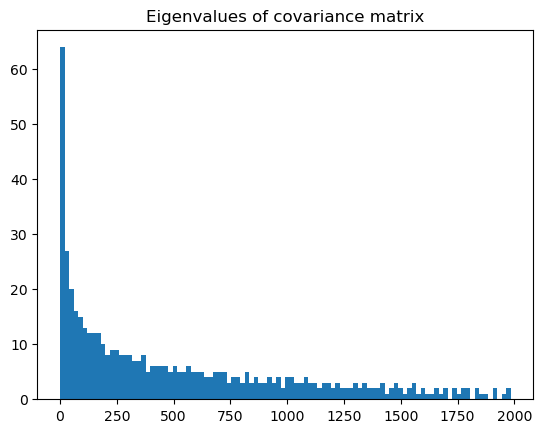

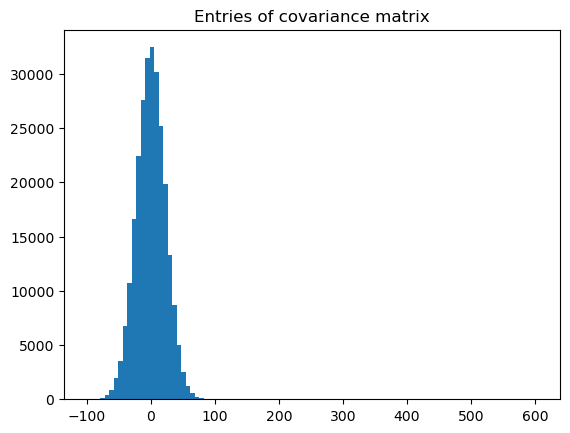

In [4]:
# Generate the toy dataset with N samples
num_samples = 100000
feature_dim = 256
num_ground_truth_features = 512
num_active_features = 5
dataset, ground_truth_features, sparse_coefficients = generate_toy_data(num_samples, feature_dim, num_ground_truth_features, num_active_features)


Text(0.5, 1.0, 'Distribution of number of non-zero coefficients')

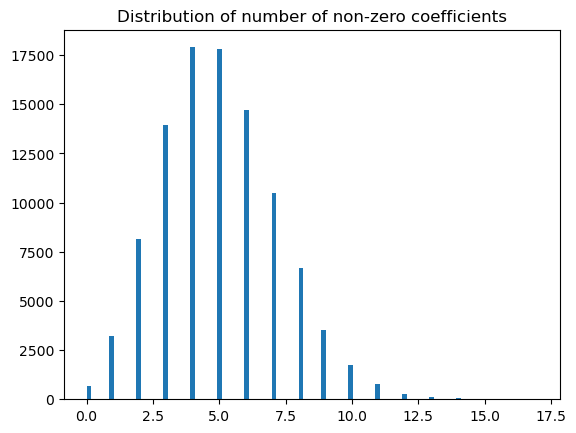

In [5]:
# Plot distribution of number of non-zero coefficients
sums = np.sum(sparse_coefficients>0, axis=1)
plt.hist(sums, bins=100)
plt.title("Distribution of number of non-zero coefficients")

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

def train_autoencoder(dataset, feature_dim, code_dim, alpha_values, num_epochs=2000, batch_size=256, lr=0.01, patience=100, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_samples = dataset.shape[0]
    dataset = torch.from_numpy(dataset).float().to(device)
    mean_cos_sims = []
    for alpha in alpha_values:
        model = Autoencoder(feature_dim, code_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, verbose=verbose, factor=0.5)
        base_loss = nn.MSELoss()
        pbar = tqdm(range(num_epochs))
        loss_history = []
        for epoch in pbar:
            X = dataset[np.random.choice(num_samples, batch_size, replace=False)].to(device)
            c, outputs = model(X)
            loss = base_loss(outputs, X)
            l1_reg = torch.abs(c).sum()
            l1_loss = alpha * l1_reg / code_dim / batch_size
            final_loss = loss + l1_loss
            loss_history.append(final_loss.item())
            optimizer.zero_grad()
            final_loss.backward()
            optimizer.step()
            scheduler.step(final_loss)
            if verbose:
                pbar.set_description(f"Loss: {final_loss.item():.2e} | L1 Loss: {l1_loss.item():.2e} | MSE Loss: {loss.item():.2e} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        decoder_weights = model.decoder.weight.detach().cpu().numpy()
        ground_truth_features = ground_truth_features
        cos_sims = np.dot(ground_truth_features.T, decoder_weights) / \
            (np.linalg.norm(ground_truth_features, axis=0)[:, None] * np.linalg.norm(decoder_weights, axis=0))
        largest_cosine_similarity = np.max(cos_sims, axis=1)
        mean_cos_sims.append(np.mean(largest_cosine_similarity))
    return mean_cos_sims

def compute_cos_sim(dataset, feature_dim, code_dim, alpha, num_epochs=2000, batch_size=256, lr=0.01, patience=100, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_samples = dataset.shape[0]
    dataset = torch.from_numpy(dataset).float().to(device)
    model = Autoencoder(feature_dim, code_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, verbose=verbose, factor=0.5)
    base_loss = nn.MSELoss()
    pbar = tqdm(range(num_epochs))
    loss_history = []
    for epoch in pbar:
        X = dataset[np.random.choice(num_samples, batch_size, replace=False)].to(device)
        c, outputs = model(X)
        loss = base_loss(outputs, X)
        l1_reg = torch.abs(c).sum()
        l1_loss = alpha * l1_reg / code_dim / batch_size
        final_loss = loss + l1_loss
        loss_history.append(final_loss.item())
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        scheduler.step(final_loss)
        if verbose:
            pbar.set_description(f"Loss: {final_loss.item():.2e} | L1 Loss: {l1_loss.item():.2e} | MSE Loss: {loss.item():.2e} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    decoder_weights = model.decoder.weight.detach().cpu().numpy()
    ground_truth_features = ground_truth_features
    cos_sims = np.dot(ground_truth_features.T, decoder_weights) / \
        (np.linalg.norm(ground_truth_features, axis=0)[:, None] * np.linalg.norm(decoder_weights, axis=0))
    largest_cosine_similarity = np.max(cos_sims, axis=1)
    mean_cos_sim = np.mean(largest_cosine_similarity)
    return mean_cos_sim

In [12]:

alpha_values = np.logspace(-3, 3, 20)
code_dim = num_ground_truth_features
for alpha in alpha_values:
    model = train_autoencoder(dataset, feature_dim, code_dim, alpha, num_epochs=2000, batch_size=256, lr=0.01)

TypeError: 'numpy.float64' object is not iterable

In [245]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.nn.init as init

batch_size = 256
num_epochs = 1000
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# if dataset is numpy array, convert it to torch tensor
if isinstance(dataset, np.ndarray):
    dataset = torch.from_numpy(dataset).float()

    
class Autoencoder(nn.Module):
    def __init__(self, feature_dim, code_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(feature_dim, code_dim)
        self.decoder = nn.Linear(code_dim, feature_dim, bias=False) # this is a dictionary of features
        init.xavier_uniform_(self.encoder.weight)
        init.orthogonal_(self.decoder.weight)
        # divide the encoder weights by sqrt(2) to make the decoder weights orthogonal to the encoder weights

    def forward(self, x):
        c = F.relu(self.encoder(x))
        prediction = self.decoder(c)
        return c, prediction

# Define the model
code_dim = num_ground_truth_features
alpha = 1.0
model = Autoencoder(feature_dim, code_dim).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, verbose=True)

# define the base loss function
base_loss = nn.MSELoss()

# Create a progress bar
pbar = tqdm(range(num_epochs))

loss_history = []

# train the model
for epoch in pbar:
    # get the data
    # choose random samples from the dataset of batch size
    X = dataset[np.random.choice(num_samples, batch_size, replace=False)].to(device)
    
    # forward pass
    c, outputs = model(X)
    loss = base_loss(outputs, X) #/ feature_dim
    
    # calculate the L1 regularization on the outputs
    l1_reg = torch.abs(c).sum()

    # add L1 regularization to the loss
    l1_loss = alpha * l1_reg / code_dim /batch_size
    final_loss = loss + l1_loss
    loss_history.append(final_loss.item())
    
    # backward pass
    optimizer.zero_grad()
    final_loss.backward()
    optimizer.step()
    scheduler.step(final_loss)
    
    # Update the progress bar description with the current loss
    # report all losses
    pbar.set_description(f"Loss: {final_loss.item():.8f} | L1 Loss: {l1_loss.item():.8f} | MSE Loss: {loss.item():.8f} | LR: {optimizer.param_groups[0]['lr']:.8f}")

#Loss: 0.00077223 | L1 Loss: 0.00025094 | MSE Loss: 0.00052130 | LR: 0.01000000: 100%|██████████| 1000/1000 [00:09<00:00, 104.61it/s]


Loss: 0.00670366 | L1 Loss: 0.00001152 | MSE Loss: 0.00669214 | LR: 0.00100000:   9%|▉         | 91/1000 [00:00<00:07, 117.15it/s]

Epoch 00074: reducing learning rate of group 0 to 1.0000e-03.


Loss: 0.00635131 | L1 Loss: 0.00000633 | MSE Loss: 0.00634498 | LR: 0.00010000:  14%|█▎        | 137/1000 [00:01<00:09, 93.08it/s] 

Epoch 00129: reducing learning rate of group 0 to 1.0000e-04.


Loss: 0.00634901 | L1 Loss: 0.00001049 | MSE Loss: 0.00633852 | LR: 0.00001000:  19%|█▉        | 191/1000 [00:01<00:07, 102.90it/s]

Epoch 00180: reducing learning rate of group 0 to 1.0000e-05.


Loss: 0.00637856 | L1 Loss: 0.00000728 | MSE Loss: 0.00637128 | LR: 0.00000100:  31%|███       | 307/1000 [00:02<00:06, 108.10it/s]

Epoch 00295: reducing learning rate of group 0 to 1.0000e-06.


Loss: 0.00674796 | L1 Loss: 0.00000141 | MSE Loss: 0.00674655 | LR: 0.00000010:  36%|███▌      | 356/1000 [00:03<00:05, 108.86it/s]

Epoch 00346: reducing learning rate of group 0 to 1.0000e-07.


Loss: 0.00641565 | L1 Loss: 0.00000302 | MSE Loss: 0.00641264 | LR: 0.00000001:  41%|████      | 406/1000 [00:03<00:05, 117.63it/s]

Epoch 00397: reducing learning rate of group 0 to 1.0000e-08.


Loss: 0.00630911 | L1 Loss: 0.00000108 | MSE Loss: 0.00630803 | LR: 0.00000001: 100%|██████████| 1000/1000 [00:08<00:00, 113.80it/s]


shape of decoder weights:  (256, 512)
mean of cosine similarities:  0.20491880516176128


(array([  3.,  26.,  68., 116., 126., 101.,  44.,  21.,   4.,   3.]),
 array([0.1107212 , 0.13220119, 0.15368117, 0.17516116, 0.19664115,
        0.21812114, 0.23960113, 0.26108112, 0.2825611 , 0.30404109,
        0.32552108]),
 <BarContainer object of 10 artists>)

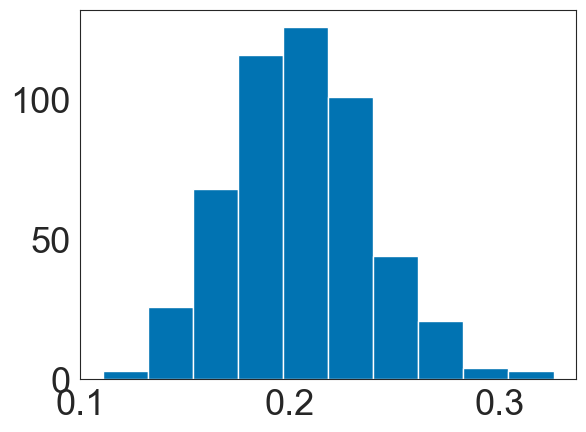

In [246]:
deocder_weights = model.decoder.weight.detach().cpu().numpy() # shape (feature_dim, code_dim)
print("shape of decoder weights: ", deocder_weights.shape)

ground_truth_features = ground_truth_features

# make a for loop over the columns of ground_truth_features
cos_sims = []
for col in range(ground_truth_features.shape[1]):
    # get the ground truth feature
    gtf = ground_truth_features[:, col]
    # now we loops over columns of the decoder weights
    largest_cosine_similarity = -1
    for col_ in range(deocder_weights.shape[1]):
        # get the decoder weight
        dw = deocder_weights[:, col_]
        # calculate the cosine similarity
        cosine_similarity = np.dot(gtf, dw)/(np.linalg.norm(gtf)*np.linalg.norm(dw))
        # update the largest cosine similarity
        if cosine_similarity > largest_cosine_similarity:
            largest_cosine_similarity = cosine_similarity
    # append the largest cosine similarity to the list
    cos_sims.append(largest_cosine_similarity)

print("mean of cosine similarities: ", np.mean(cos_sims))
        
plt.hist(cos_sims)


Loss: 6.91e-05 | L1 Loss: 5.91e-05 | MSE Loss: 1.00e-05 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:13<00:00, 146.09it/s]


0.001 0.38964049563997216


Loss: 7.74e-05 | L1 Loss: 6.85e-05 | MSE Loss: 8.88e-06 | LR: 9.77e-06: 100%|██████████| 2000/2000 [00:14<00:00, 141.40it/s]


0.0011497569953977356 0.388001967221333


Loss: 8.31e-05 | L1 Loss: 7.32e-05 | MSE Loss: 9.93e-06 | LR: 3.91e-05: 100%|██████████| 2000/2000 [00:15<00:00, 132.02it/s]


0.0013219411484660286 0.38986067898672044


Loss: 9.24e-05 | L1 Loss: 7.86e-05 | MSE Loss: 1.37e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 140.93it/s]


0.0015199110829529332 0.39114128149678556


Loss: 1.02e-04 | L1 Loss: 8.51e-05 | MSE Loss: 1.73e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 136.04it/s]


0.001747528400007683 0.39317234343451746


Loss: 1.14e-04 | L1 Loss: 9.66e-05 | MSE Loss: 1.78e-05 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:13<00:00, 144.18it/s]


0.002009233002565048 0.39970264728083593


Loss: 1.28e-04 | L1 Loss: 1.10e-04 | MSE Loss: 1.79e-05 | LR: 3.91e-05: 100%|██████████| 2000/2000 [00:14<00:00, 140.33it/s]


0.0023101297000831605 0.40737810713915096


Loss: 1.33e-04 | L1 Loss: 1.11e-04 | MSE Loss: 2.20e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 137.00it/s]


0.0026560877829466868 0.41636701478525207


Loss: 1.45e-04 | L1 Loss: 1.19e-04 | MSE Loss: 2.63e-05 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:14<00:00, 141.19it/s]


0.0030538555088334154 0.4098819970121711


Loss: 1.62e-04 | L1 Loss: 1.33e-04 | MSE Loss: 2.89e-05 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:13<00:00, 143.77it/s]


0.003511191734215131 0.42473574197629543


Loss: 1.62e-04 | L1 Loss: 1.41e-04 | MSE Loss: 2.15e-05 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:14<00:00, 134.14it/s]


0.004037017258596553 0.42171411391391306


Loss: 1.86e-04 | L1 Loss: 1.49e-04 | MSE Loss: 3.74e-05 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:14<00:00, 140.37it/s]


0.004641588833612782 0.4413618384674485


Loss: 1.94e-04 | L1 Loss: 1.58e-04 | MSE Loss: 3.57e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 141.23it/s]


0.005336699231206312 0.4382362034004173


Loss: 2.42e-04 | L1 Loss: 1.90e-04 | MSE Loss: 5.20e-05 | LR: 3.91e-05: 100%|██████████| 2000/2000 [00:14<00:00, 140.43it/s]


0.006135907273413176 0.4543290039852471


Loss: 2.35e-04 | L1 Loss: 1.78e-04 | MSE Loss: 5.71e-05 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:15<00:00, 132.86it/s]


0.007054802310718645 0.46999656280872093


Loss: 2.37e-04 | L1 Loss: 1.93e-04 | MSE Loss: 4.45e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 141.91it/s]


0.008111308307896872 0.4682965523250834


Loss: 2.72e-04 | L1 Loss: 2.09e-04 | MSE Loss: 6.32e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:13<00:00, 142.87it/s]


0.0093260334688322 0.4836913852546625


Loss: 2.78e-04 | L1 Loss: 2.16e-04 | MSE Loss: 6.19e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 136.86it/s]


0.010722672220103232 0.49003382722704


Loss: 3.13e-04 | L1 Loss: 2.32e-04 | MSE Loss: 8.09e-05 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 140.94it/s]


0.012328467394420659 0.5153461047173556


Loss: 3.71e-04 | L1 Loss: 2.65e-04 | MSE Loss: 1.06e-04 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:13<00:00, 146.10it/s]


0.014174741629268055 0.509971213192727


Loss: 3.72e-04 | L1 Loss: 2.61e-04 | MSE Loss: 1.11e-04 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:16<00:00, 124.54it/s]


0.016297508346206444 0.5476552536261706


Loss: 4.04e-04 | L1 Loss: 2.85e-04 | MSE Loss: 1.19e-04 | LR: 3.91e-05: 100%|██████████| 2000/2000 [00:17<00:00, 115.61it/s]


0.01873817422860384 0.5192706764071159


Loss: 4.58e-04 | L1 Loss: 3.09e-04 | MSE Loss: 1.49e-04 | LR: 3.91e-05: 100%|██████████| 2000/2000 [00:16<00:00, 117.77it/s]


0.021544346900318846 0.5621976908397852


Loss: 4.97e-04 | L1 Loss: 3.17e-04 | MSE Loss: 1.79e-04 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:16<00:00, 123.00it/s]


0.024770763559917114 0.583100657881485


Loss: 4.69e-04 | L1 Loss: 2.97e-04 | MSE Loss: 1.72e-04 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:14<00:00, 142.63it/s]


0.02848035868435802 0.614579888794183


Loss: 5.40e-04 | L1 Loss: 3.05e-04 | MSE Loss: 2.35e-04 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:14<00:00, 142.79it/s]


0.03274549162877728 0.643521719061265


Loss: 5.83e-04 | L1 Loss: 3.47e-04 | MSE Loss: 2.36e-04 | LR: 1.95e-05: 100%|██████████| 2000/2000 [00:14<00:00, 141.81it/s]


0.037649358067924674 0.6303018991878728


Loss: 5.94e-04 | L1 Loss: 3.03e-04 | MSE Loss: 2.92e-04 | LR: 3.91e-05: 100%|██████████| 2000/2000 [00:17<00:00, 115.47it/s]


0.04328761281083059 0.7186406195757293


Loss: 4.33e-04 | L1 Loss: 1.59e-04 | MSE Loss: 2.75e-04 | LR: 6.25e-04: 100%|██████████| 2000/2000 [00:17<00:00, 115.96it/s]


0.049770235643321115 0.9681605406249785


Loss: 6.65e-04 | L1 Loss: 3.09e-04 | MSE Loss: 3.56e-04 | LR: 1.56e-04: 100%|██████████| 2000/2000 [00:16<00:00, 120.09it/s]


0.05722367659350217 0.7611511405869966


Loss: 4.31e-04 | L1 Loss: 1.88e-04 | MSE Loss: 2.43e-04 | LR: 1.25e-03: 100%|██████████| 2000/2000 [00:17<00:00, 116.25it/s]


0.06579332246575682 0.9842874022991506


Loss: 4.94e-04 | L1 Loss: 2.14e-04 | MSE Loss: 2.80e-04 | LR: 6.25e-04: 100%|██████████| 2000/2000 [00:15<00:00, 127.23it/s]


0.07564633275546291 0.9730133600619609


Loss: 5.67e-04 | L1 Loss: 2.33e-04 | MSE Loss: 3.34e-04 | LR: 1.25e-03: 100%|██████████| 2000/2000 [00:14<00:00, 139.47it/s]


0.08697490026177834 0.9630509155199609


Loss: 6.03e-04 | L1 Loss: 2.78e-04 | MSE Loss: 3.25e-04 | LR: 3.91e-05: 100%|██████████| 2000/2000 [00:15<00:00, 128.58it/s]


0.1 0.9673395411748779


Loss: 5.72e-04 | L1 Loss: 2.74e-04 | MSE Loss: 2.98e-04 | LR: 6.25e-04: 100%|██████████| 2000/2000 [00:13<00:00, 143.72it/s]


0.11497569953977356 0.9683933460899721


Loss: 7.66e-04 | L1 Loss: 3.31e-04 | MSE Loss: 4.35e-04 | LR: 7.81e-05: 100%|██████████| 2000/2000 [00:13<00:00, 142.93it/s]


0.13219411484660287 0.95608158387595


Loss: 6.98e-04 | L1 Loss: 3.06e-04 | MSE Loss: 3.92e-04 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:16<00:00, 120.51it/s]


0.1519911082952933 0.9591178080530472


Loss: 8.61e-04 | L1 Loss: 3.42e-04 | MSE Loss: 5.20e-04 | LR: 1.25e-03: 100%|██████████| 2000/2000 [00:14<00:00, 141.70it/s]


0.1747528400007685 0.931165411601889


Loss: 1.24e-03 | L1 Loss: 4.64e-04 | MSE Loss: 7.74e-04 | LR: 4.88e-06: 100%|██████████| 2000/2000 [00:14<00:00, 141.40it/s]


0.2009233002565048 0.9002597792569007


Loss: 1.34e-03 | L1 Loss: 5.06e-04 | MSE Loss: 8.33e-04 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:16<00:00, 121.00it/s]


0.23101297000831605 0.8686699209601313


Loss: 1.54e-03 | L1 Loss: 6.20e-04 | MSE Loss: 9.21e-04 | LR: 6.25e-04: 100%|██████████| 2000/2000 [00:15<00:00, 128.17it/s]


0.26560877829466867 0.8053409377695551


Loss: 1.68e-03 | L1 Loss: 7.11e-04 | MSE Loss: 9.73e-04 | LR: 6.25e-04: 100%|██████████| 2000/2000 [00:14<00:00, 141.07it/s]


0.30538555088334157 0.753105333885555


Loss: 2.01e-03 | L1 Loss: 8.10e-04 | MSE Loss: 1.20e-03 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:14<00:00, 134.72it/s]


0.3511191734215131 0.7069560070618806


Loss: 2.23e-03 | L1 Loss: 8.21e-04 | MSE Loss: 1.41e-03 | LR: 6.25e-04: 100%|██████████| 2000/2000 [00:14<00:00, 142.70it/s]


0.40370172585965536 0.7007673577754663


Loss: 2.58e-03 | L1 Loss: 9.38e-04 | MSE Loss: 1.64e-03 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:14<00:00, 141.95it/s]


0.4641588833612782 0.5793624324633695


Loss: 3.14e-03 | L1 Loss: 1.04e-03 | MSE Loss: 2.10e-03 | LR: 3.13e-04: 100%|██████████| 2000/2000 [00:15<00:00, 129.00it/s]


0.5336699231206312 0.45244202972709313


Loss: 5.18e-03 | L1 Loss: 5.37e-04 | MSE Loss: 4.64e-03 | LR: 6.10e-07: 100%|██████████| 2000/2000 [00:14<00:00, 137.96it/s]


0.6135907273413176 0.31069513780224994


Loss: 6.61e-03 | L1 Loss: 1.28e-04 | MSE Loss: 6.48e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 142.67it/s]


0.7054802310718645 0.23399843580823382


Loss: 6.47e-03 | L1 Loss: 9.41e-05 | MSE Loss: 6.38e-03 | LR: 3.05e-07: 100%|██████████| 2000/2000 [00:15<00:00, 132.46it/s]


0.8111308307896873 0.22674178222619723


Loss: 6.18e-03 | L1 Loss: 5.66e-05 | MSE Loss: 6.12e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:16<00:00, 122.55it/s]


0.9326033468832199 0.215215177722084


Loss: 6.72e-03 | L1 Loss: 8.68e-08 | MSE Loss: 6.72e-03 | LR: 1.91e-08: 100%|██████████| 2000/2000 [00:13<00:00, 143.01it/s]


1.072267222010323 0.21120765102595862


Loss: 6.63e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.63e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:15<00:00, 131.07it/s]


1.232846739442066 0.21050532661710206


Loss: 6.27e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.27e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:15<00:00, 126.68it/s]


1.4174741629268048 0.20881377461026485


Loss: 6.61e-03 | L1 Loss: 4.71e-07 | MSE Loss: 6.61e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.94it/s]


1.629750834620645 0.2151030378217113


Loss: 6.29e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.29e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 140.81it/s]


1.873817422860385 0.20757376475714662


Loss: 6.57e-03 | L1 Loss: 2.38e-06 | MSE Loss: 6.57e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:13<00:00, 151.41it/s]


2.1544346900318843 0.2066358090212596


Loss: 7.01e-03 | L1 Loss: 6.00e-06 | MSE Loss: 7.00e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:11<00:00, 169.21it/s]


2.4770763559917115 0.20364117620185754


Loss: 6.55e-03 | L1 Loss: 1.27e-07 | MSE Loss: 6.55e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:11<00:00, 168.48it/s]


2.848035868435802 0.20674430716089592


Loss: 5.98e-03 | L1 Loss: 3.19e-07 | MSE Loss: 5.98e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:13<00:00, 150.66it/s]


3.2745491628777286 0.20246830780383998


Loss: 6.34e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.34e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.87it/s]


3.7649358067924674 0.20779326838219678


Loss: 6.41e-03 | L1 Loss: 3.73e-06 | MSE Loss: 6.41e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 140.63it/s]


4.328761281083062 0.20874909116996682


Loss: 6.62e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.62e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 142.32it/s]


4.9770235643321135 0.20429533265993322


Loss: 6.50e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.50e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 142.08it/s]


5.72236765935022 0.20690842425736658


Loss: 6.11e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.11e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 140.54it/s]


6.5793322465756825 0.20583172460774032


Loss: 6.66e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.66e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 140.78it/s]


7.56463327554629 0.20681640511337734


Loss: 6.73e-03 | L1 Loss: 4.48e-07 | MSE Loss: 6.72e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 140.85it/s]


8.697490026177835 0.20960731941116964


Loss: 6.23e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.23e-03 | LR: 3.05e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.74it/s]


10.0 0.20630931236281297


Loss: 6.17e-03 | L1 Loss: 1.76e-06 | MSE Loss: 6.16e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.45it/s]


11.497569953977356 0.20998414991522804


Loss: 6.31e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.31e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 140.80it/s]


13.219411484660288 0.20295014321093677


Loss: 6.99e-03 | L1 Loss: 2.11e-06 | MSE Loss: 6.99e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.81it/s]


15.199110829529332 0.20477086521232574


Loss: 6.75e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.75e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 142.45it/s]


17.47528400007683 0.20519205016858544


Loss: 6.53e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.53e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.72it/s]


20.09233002565046 0.2032567946366836


Loss: 6.78e-03 | L1 Loss: 6.98e-06 | MSE Loss: 6.78e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.92it/s]


23.10129700083158 0.20611213762447111


Loss: 6.42e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.42e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 142.54it/s]


26.560877829466893 0.20455588324228755


Loss: 6.75e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.75e-03 | LR: 3.05e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.04it/s]


30.538555088334185 0.20833671904433648


Loss: 6.26e-03 | L1 Loss: 7.96e-08 | MSE Loss: 6.26e-03 | LR: 6.10e-07: 100%|██████████| 2000/2000 [00:14<00:00, 142.17it/s]


35.111917342151344 0.21345628750176754


Loss: 6.21e-03 | L1 Loss: 3.00e-06 | MSE Loss: 6.21e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:13<00:00, 143.35it/s]


40.37017258596558 0.20889215002483463


Loss: 7.23e-03 | L1 Loss: 0.00e+00 | MSE Loss: 7.23e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.57it/s]


46.41588833612782 0.20569049570526915


Loss: 6.43e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.43e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.27it/s]


53.366992312063125 0.20705435287537236


Loss: 6.81e-03 | L1 Loss: 1.37e-05 | MSE Loss: 6.80e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.59it/s]


61.35907273413176 0.20796699532633306


Loss: 6.44e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.44e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.11it/s]


70.54802310718645 0.20935834631375513


Loss: 6.34e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.34e-03 | LR: 6.10e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.01it/s]


81.11308307896873 0.2025063302857916


Loss: 7.02e-03 | L1 Loss: 1.01e-05 | MSE Loss: 7.01e-03 | LR: 6.10e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.34it/s]


93.26033468832199 0.20617580134781238


Loss: 5.99e-03 | L1 Loss: 0.00e+00 | MSE Loss: 5.99e-03 | LR: 6.10e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.38it/s]


107.22672220103232 0.20853545923059194


Loss: 6.43e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.43e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 140.93it/s]


123.28467394420659 0.20643453051170774


Loss: 6.56e-03 | L1 Loss: 2.17e-05 | MSE Loss: 6.54e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.31it/s]


141.74741629268047 0.20594807679315974


Loss: 6.42e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.42e-03 | LR: 3.05e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.66it/s]


162.97508346206433 0.2096997301323824


Loss: 6.48e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.48e-03 | LR: 3.05e-07: 100%|██████████| 2000/2000 [00:14<00:00, 140.22it/s]


187.3817422860383 0.21140314945113442


Loss: 6.22e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.22e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.03it/s]


215.44346900318865 0.20774558989056233


Loss: 6.40e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.40e-03 | LR: 3.05e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.05it/s]


247.7076355991714 0.2056465571106804


Loss: 6.06e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.06e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.17it/s]


284.8035868435805 0.20659117103226676


Loss: 6.29e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.29e-03 | LR: 3.81e-08: 100%|██████████| 2000/2000 [00:14<00:00, 140.47it/s]


327.4549162877732 0.20745273536820236


Loss: 6.23e-03 | L1 Loss: 8.40e-07 | MSE Loss: 6.23e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 140.73it/s]


376.49358067924715 0.20545826585337124


Loss: 6.44e-03 | L1 Loss: 2.27e-05 | MSE Loss: 6.42e-03 | LR: 3.05e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.03it/s]


432.87612810830615 0.20579024797366413


Loss: 6.65e-03 | L1 Loss: 5.96e-06 | MSE Loss: 6.64e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.06it/s]


497.7023564332114 0.2039765675303505


Loss: 6.71e-03 | L1 Loss: 3.73e-05 | MSE Loss: 6.67e-03 | LR: 6.10e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.91it/s]


572.236765935022 0.20556954874518174


Loss: 6.19e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.19e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 140.85it/s]


657.9332246575682 0.20980313463664405


Loss: 8.84e-03 | L1 Loss: 2.41e-03 | MSE Loss: 6.43e-03 | LR: 7.63e-08: 100%|██████████| 2000/2000 [00:14<00:00, 141.15it/s]


756.463327554629 0.20687823690436347


Loss: 6.52e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.52e-03 | LR: 1.53e-07: 100%|██████████| 2000/2000 [00:14<00:00, 141.58it/s]


869.7490026177834 0.20348094076890177


Loss: 6.26e-03 | L1 Loss: 0.00e+00 | MSE Loss: 6.26e-03 | LR: 2.44e-06: 100%|██████████| 2000/2000 [00:14<00:00, 142.61it/s]


1000.0 0.20827259142540894


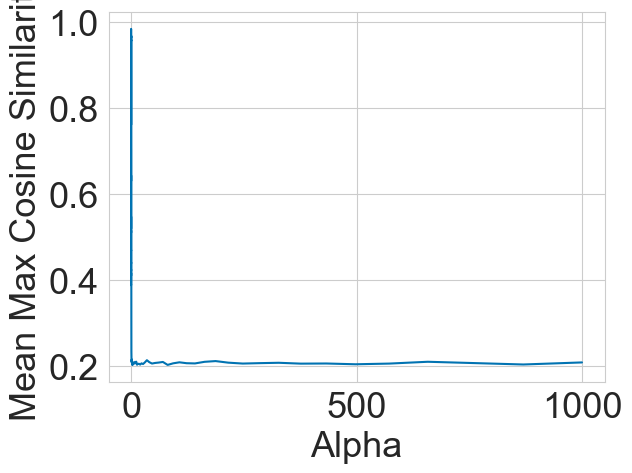

In [196]:
alpha_values = np.logspace(-3, 3, 100)
mean_cos_sims = []
num_epochs = 2000
batch_size = 256
dataset = torch.from_numpy(dataset).float().to(device)
for alpha in alpha_values:
    model = Autoencoder(feature_dim, code_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, verbose=False, factor=0.5)
        # define the base loss function
    base_loss = nn.MSELoss()

    # Create a progress bar
    pbar = tqdm(range(num_epochs))

    loss_history = []

    # train the model
    for epoch in pbar:
        # get the data
        # choose random samples from the dataset of batch size
        X = dataset[np.random.choice(num_samples, batch_size, replace=False)].to(device)
        
        # forward pass
        c, outputs = model(X)
        loss = base_loss(outputs, X)
        
        # calculate the L1 regularization on the outputs
        l1_reg = torch.abs(c).sum()

        # add L1 regularization to the loss
        l1_loss = alpha * l1_reg / code_dim / batch_size
        final_loss = loss + l1_loss
        loss_history.append(final_loss.item())
        
        # backward pass
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        scheduler.step(final_loss)
        
        # Update the progress bar description with the current loss
        # report all losses
        pbar.set_description(f"Loss: {final_loss.item():.2e} | L1 Loss: {l1_loss.item():.2e} | MSE Loss: {loss.item():.2e} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    decoder_weights = model.decoder.weight.detach().cpu().numpy()
    ground_truth_features = ground_truth_features

    cos_sims = np.dot(ground_truth_features.T, decoder_weights) / \
        (np.linalg.norm(ground_truth_features, axis=0)[:, None] * np.linalg.norm(decoder_weights, axis=0))
    largest_cosine_similarity = np.max(cos_sims, axis=1)
    mean_cos_sims.append(np.mean(largest_cosine_similarity))
    print(alpha, np.mean(largest_cosine_similarity))
    #print("alpha: ", alpha, "mean of cosine similarities: ", np.mean(cos_sims))

plt.plot(alpha_values, mean_cos_sims)
plt.xlabel('Alpha')
plt.ylabel('Mean Max Cosine Similarity')
plt.show()


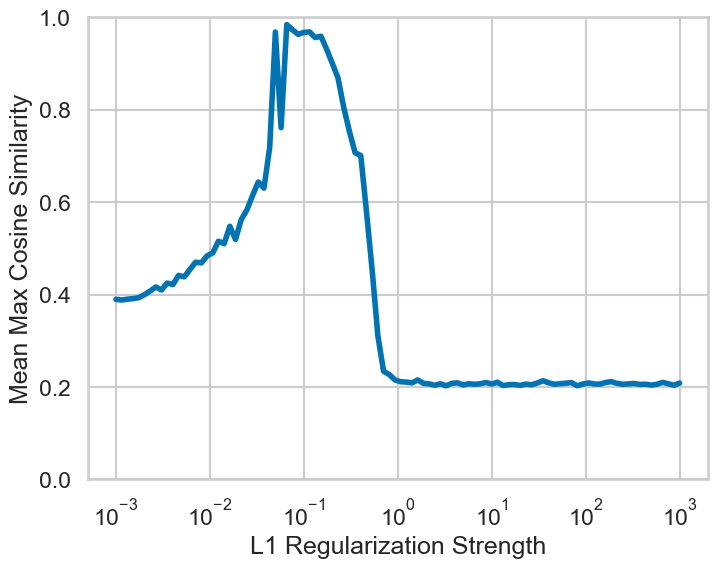

In [254]:
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('colorblind')
sns.set_context('talk')

plt.figure(figsize=(8, 6))
sns.lineplot(x=alpha_values, y=mean_cos_sims, lw=4)
plt.xlabel('L1 Regularization Strength')
plt.ylabel('Mean Max Cosine Similarity')
plt.xscale('log')
plt.ylim([0, 1])
plt.show()


code_dim_values:  [   51    73   105   152   219   315   453   652   938  1349  1941  2793
  4017  5779  8313 11958 17202 24744 35593 51200]
code_dim:  51


Loss: 6.40e-03 | L1 Loss: 8.33e-06 | MSE Loss: 6.39e-03 | LR: 3.91e-05: 100%|██████████| 1000/1000 [00:07<00:00, 136.03it/s]


51 0.1853369776060418
code_dim:  73


Loss: 6.06e-03 | L1 Loss: 4.23e-04 | MSE Loss: 5.63e-03 | LR: 1.25e-03: 100%|██████████| 1000/1000 [00:07<00:00, 140.00it/s]


73 0.3076322377482398
code_dim:  105


Loss: 3.92e-03 | L1 Loss: 8.87e-04 | MSE Loss: 3.03e-03 | LR: 1.25e-03: 100%|██████████| 1000/1000 [00:07<00:00, 133.70it/s]


105 0.38611930643470266
code_dim:  152


Loss: 2.93e-03 | L1 Loss: 9.19e-04 | MSE Loss: 2.01e-03 | LR: 2.50e-03: 100%|██████████| 1000/1000 [00:07<00:00, 125.18it/s]


152 0.45060699248800173
code_dim:  219


Loss: 1.94e-03 | L1 Loss: 9.05e-04 | MSE Loss: 1.03e-03 | LR: 2.50e-03: 100%|██████████| 1000/1000 [00:07<00:00, 136.46it/s]


219 0.5063442343897594
code_dim:  315


Loss: 1.88e-03 | L1 Loss: 6.56e-04 | MSE Loss: 1.23e-03 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:06<00:00, 144.04it/s]


315 0.6370919314578041
code_dim:  453


Loss: 1.17e-03 | L1 Loss: 3.23e-04 | MSE Loss: 8.43e-04 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:07<00:00, 138.53it/s]


453 0.8786541521875286
code_dim:  652


Loss: 6.61e-04 | L1 Loss: 2.52e-04 | MSE Loss: 4.09e-04 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:07<00:00, 125.94it/s]


652 0.9935411931464477
code_dim:  938


Loss: 5.42e-04 | L1 Loss: 1.91e-04 | MSE Loss: 3.51e-04 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:08<00:00, 119.66it/s]


938 0.9907380400193541
code_dim:  1349


Loss: 7.05e-04 | L1 Loss: 1.35e-04 | MSE Loss: 5.71e-04 | LR: 1.00e-02: 100%|██████████| 1000/1000 [00:06<00:00, 153.28it/s]


1349 0.974935146753189
code_dim:  1941


Loss: 5.79e-04 | L1 Loss: 2.84e-04 | MSE Loss: 2.95e-04 | LR: 2.50e-03: 100%|██████████| 1000/1000 [00:06<00:00, 152.32it/s]


1941 0.7132589449325429
code_dim:  2793


Loss: 4.64e-04 | L1 Loss: 1.49e-04 | MSE Loss: 3.15e-04 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:07<00:00, 142.76it/s]


2793 0.85298555089881
code_dim:  4017


Loss: 3.09e-04 | L1 Loss: 1.20e-04 | MSE Loss: 1.89e-04 | LR: 2.50e-03: 100%|██████████| 1000/1000 [00:07<00:00, 135.93it/s]


4017 0.8912083520902019
code_dim:  5779


Loss: 2.91e-04 | L1 Loss: 6.38e-05 | MSE Loss: 2.27e-04 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:08<00:00, 120.81it/s]


5779 0.9554229783188576
code_dim:  8313


Loss: 3.26e-04 | L1 Loss: 5.68e-05 | MSE Loss: 2.69e-04 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:09<00:00, 107.94it/s]


8313 0.9543133220557474
code_dim:  11958


Loss: 4.52e-04 | L1 Loss: 3.47e-05 | MSE Loss: 4.17e-04 | LR: 2.50e-03: 100%|██████████| 1000/1000 [00:10<00:00, 93.50it/s]


11958 0.9628406979966809
code_dim:  17202


Loss: 4.61e-04 | L1 Loss: 5.76e-05 | MSE Loss: 4.03e-04 | LR: 5.00e-03: 100%|██████████| 1000/1000 [00:13<00:00, 75.42it/s]


17202 0.89362321191584
code_dim:  24744


Loss: 9.16e-04 | L1 Loss: 4.10e-05 | MSE Loss: 8.75e-04 | LR: 1.25e-03: 100%|██████████| 1000/1000 [00:16<00:00, 60.54it/s]


24744 0.8405744241006854
code_dim:  35593


Loss: 1.02e-03 | L1 Loss: 5.04e-05 | MSE Loss: 9.71e-04 | LR: 2.50e-03: 100%|██████████| 1000/1000 [00:21<00:00, 47.53it/s]


35593 0.7663546946059322
code_dim:  51200


Loss: 1.60e-03 | L1 Loss: 3.50e-05 | MSE Loss: 1.57e-03 | LR: 1.25e-03: 100%|██████████| 1000/1000 [00:26<00:00, 37.99it/s]


51200 0.7491496279967538


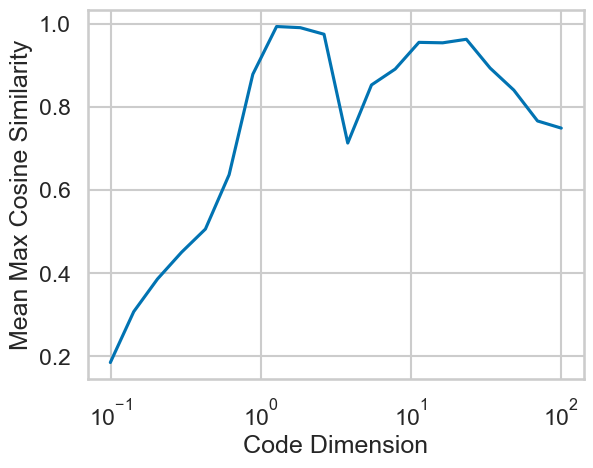

In [264]:
code_dim_values = num_ground_truth_features*np.logspace(-1, 2, 20)
alpha = 0.1
mean_cos_sims = []

# make sure code_dim_values is a numpy array of ints
code_dim_values = code_dim_values.astype(int)
print("code_dim_values: ", code_dim_values)

# if dataset is a numpy array, convert it to a torch tensor
if isinstance(dataset, np.ndarray):
    dataset = torch.from_numpy(dataset).float().to(device)

# loop over the code_dim values
for code_dim in code_dim_values:
    print("code_dim: ", code_dim)
    model = Autoencoder(feature_dim, code_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, verbose=False, factor=0.5)
    base_loss = nn.MSELoss()

    pbar = tqdm(range(num_epochs))
    loss_history = []

    for epoch in pbar:
        X = dataset[np.random.choice(num_samples, batch_size, replace=False)].to(device)
        c, outputs = model(X)
        loss = base_loss(outputs, X)
        l1_reg = torch.abs(c).sum()
        l1_loss = alpha * l1_reg / code_dim / batch_size
        final_loss = loss + l1_loss
        loss_history.append(final_loss.item())

        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        scheduler.step(final_loss)

        pbar.set_description(f"Loss: {final_loss.item():.2e} | L1 Loss: {l1_loss.item():.2e} | MSE Loss: {loss.item():.2e} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    decoder_weights = model.decoder.weight.detach().cpu().numpy()
    ground_truth_features = ground_truth_features

    cos_sims = np.dot(ground_truth_features.T, decoder_weights) / \
        (np.linalg.norm(ground_truth_features, axis=0)[:, None] * np.linalg.norm(decoder_weights, axis=0))
    largest_cosine_similarity = np.max(cos_sims, axis=1)
    mean_cos_sims.append(np.mean(largest_cosine_similarity))
    print(code_dim, np.mean(largest_cosine_similarity))

plt.plot(code_dim_values/num_ground_truth_features, mean_cos_sims)
plt.xlabel('Code Dimension')
plt.ylabel('Mean Max Cosine Similarity')
plt.xscale('log')
plt.show()